# Efficient Data Stream Anomaly Detection

Python script capable of detecting anomalies in a continuous data stream. This stream, simulating real-time sequences of floating numbers, could represent various metrics such as financial transaction or system metrics. Focus will be on identifying unusual patterns, such as exceptionally high values or deviation from the norm.

## Git command

In [7]:
#init git everytime running script
#!git init 

#connect to remote github repository using url
#!git remote add origin https://github.com/haziq2010443/Data-Stream-Anomaly-Detection.git

#commit changes with message
#!git commit -m "Try First Commit with Jupyter Notebook"

#push changes to remote repository on master branch
#!git push -u origin master

#pull recent changes to jupyter notebook
#!git pull

## Import Necessary Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from adwin import adwin
from scipy.stats import zscore

ModuleNotFoundError: No module named 'adwin'

In [15]:
import adwin

ModuleNotFoundError: No module named 'adwin'

## Simulating a Real-Time Data Stream

### Function to Simulate Data Stream

This function generates a multivariate data stream with regular patterns, seasonal elements, & random noises

In [6]:
def simulate_data_stream(num_points=1000, seasonal_frequency=100, seasonal_amplitude=10, noise_level=2):
    timestamps = []
    metric_1 = []
    metric_2 = []
    metric_3 = []

    for t in range(num_points):
        timestamps.append(t)

        metric_1_value = (0.01 * t) + seasonal_amplitude * np.sin(2 * np.pi * t / seasonal_frequency) + np.random.normal(0, noise_level)
        metric_1.append(metric_1_value)
        
        metric_2_value = (0.005 * t) + seasonal_amplitude * np.sin(2 * np.pi * t / (seasonal_frequency * 1.5)) + np.random.normal(0, noise_level)
        metric_2.append(metric_2_value)
        
        metric_3_value = (-0.008 * t) + seasonal_amplitude * np.sin(2 * np.pi * t / (seasonal_frequency * 2)) + np.random.normal(0, noise_level)
        metric_3.append(metric_3_value)

        time.sleep(0.01)

    data_stream = pd.DataFrame({
        'timestamp': timestamps,
        'metric_1': metric_1,
        'metric_2': metric_2,
        'metric_3': metric_3
    })

    return data_stream

### Plot the Simulated Data Stream

Observe the trend of the simulated data stream

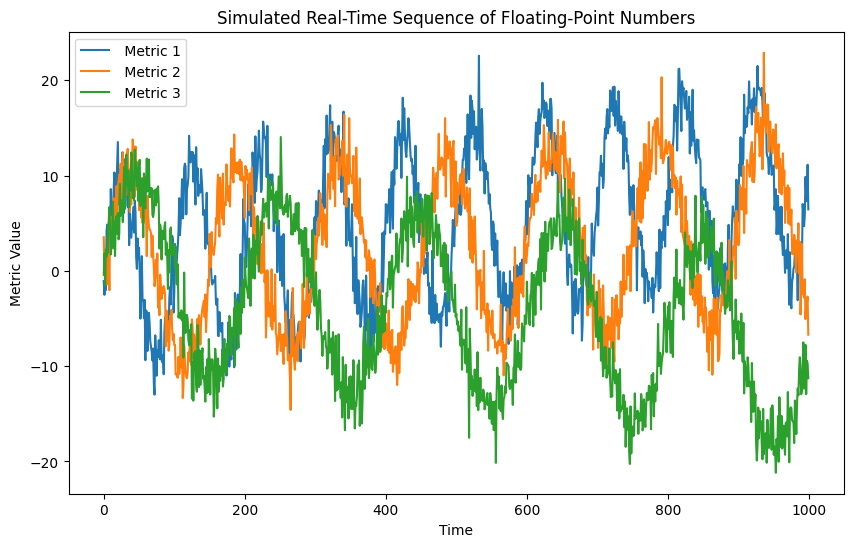

In [7]:
data_stream = simulate_data_stream()

plt.figure(figsize=(10,6))
plt.plot(data_stream['timestamp'], data_stream['metric_1'], label=' Metric 1')
plt.plot(data_stream['timestamp'], data_stream['metric_2'], label=' Metric 2')
plt.plot(data_stream['timestamp'], data_stream['metric_3'], label=' Metric 3')
plt.title('Simulated Real-Time Sequence of Floating-Point Numbers')
plt.xlabel('Time')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

## Anomaly Detection